# Large-area metalens

<!--  ![image.png =10x](img/metalens_drawing.png) -->
<!--  <img src="./img/metalens_drawing.png" alt="drawing" width="1000"/> -->

## Introduction

See on [github](https://github.com/flexcompute/tidy3d-notebooks/blob/main/Metalens.ipynb), run on [colab](https://colab.research.google.com/github/flexcompute/tidy3d-notebooks/blob/main/Metalens.ipynb), or just follow along with the output below.

Here we use Tidy3D to simulate a very large dielectric metalens.   We base this example off of the recent paper from Khorasaninejad et al. titled [_Metalenses at visible wavelengths: Diffraction-limited focusing and subwavelength resolution imaging_](https://science.sciencemag.org/content/352/6290/1190), which was recently published in Science.  In this paper, a 2-dimensional array of dielectric structures is used as a lens to focus transmitted light to a single position directly above the device.

Typically, these structures are simulated by simulating each dielectric unit cell individually to compute a phase and amplitude transmittance for each cell.  While this approach makes for an approximation of the overall device performance, it would be useful to be able to simulate the *entire* device as a whole to capture the entire physics.  However, a simulation of this scale requires several hours or days to do with a conventional CPU-based FDTD.  With Tidy3D, we are able to complete the entire simulation in about 1 minute!

## Setup

We first perform basic imports of the packages needed.

In [1]:
# make sure notebook plots inline
%matplotlib inline

# standard python imports
import numpy as np
from numpy import random
import matplotlib.pyplot as plt

import sys; sys.path.append('..')
# tidy3D import
import tidy3d as td
from tidy3d import web

## Define Simulation Parameters

We now set the basic parameters that define the metalens.  The following image (taken from the original paper) define the variables describing the unit cell of the metalens.   The angle of each cell (θ) is chosen for maximum focusing effect.  Note that microns are the default spatial unit in Tidy3D.

<!-- ![image.png](img/metalens_diagram.png) -->
 <img src="img/metalens_diagram.png" alt="diagram" width="700"/>

In [2]:
# 1 nanometer in units of microns (for conversion)
nm = 1e-3

# free space central wavelength
wavelength = 600 * nm

# desired numerical aperture
NA = 0.5

# shape parameters of metalens unit cell (um) (refer to image above and see paper for details)
W = 85 * nm
L = 410 * nm
H = 600 * nm
S = 430 * nm

# space between bottom PML and substrate (-z)
space_below_sub = 1 * wavelength

# thickness of substrate
thickness_sub = 100 * nm

# side length of entire metalens (um)
side_length = 10

# Number of unit cells in each x and y direction (NxN grid)
N = int(side_length / S)
print(f'for diameter of {side_length:.1f} um, have {N} cells per side')
print(f'full metalens has area of {side_length**2:.1f} um^2 and {N*N} total cells')

# Define material properties at 600 nm
n_TiO2 = 2.40
n_SiO2 = 1.46
air = td.Medium(permittivity=1.0)
SiO2 = td.Medium(permittivity=n_SiO2**2)
TiO2 = td.Medium(permittivity=n_TiO2**2)

# resolution control
grids_per_wavelength = 25

# Number of PML layers to use along z direction
npml = 10

for diameter of 10.0 um, have 23 cells per side
full metalens has area of 100.0 um^2 and 529 total cells


## Process Geometry

Next we need to do conversions to get the problem parameters ready to define the simulation.

In [3]:
# grid size (um)
dl = wavelength / grids_per_wavelength

# using the wavelength in microns, one can use td.C_0 (um/s) to get frequency in Hz
# wavelength_meters = wavelength * meters
f0 = td.C_0 / wavelength

# Define PML layers, for this we have no PML in x, y but `npml` cells in z
pml_layers = [td.PMLLayer(num_layers=0), td.PMLLayer(num_layers=0), td.PMLLayer(num_layers=10)]

# Compute the domain size in x, y (note: round down from side_length)
length_xy = N * S

# focal length given diameter and numerical aperture
f = length_xy / 2 / NA * np.sqrt(1 - NA**2)

# Function describing the theoretical best angle of each box at position (x,y).  see paper for details
def theta(x, y):
    return np.pi / wavelength * (f - np.sqrt(x ** 2 + y ** 2 + f ** 2))

# total domain size in z: (space -> substrate -> unit cell -> 1.7 focal lengths)
length_z = space_below_sub + thickness_sub + H + 1.7 * f

# construct simulation size array
sim_size = (length_xy, length_xy, length_z)

## Create Metalens Geometry

Now we can automatically generate a large metalens structure using these parameters.

We will first create the substrate as a [td.Box](../generated/tidy3d.Box.rst)

Then, we will loop through the x and y coordinates of the lens and create each unit cell as a [td.PolySlab](../generated/tidy3d.PolySlab.rst)

In [4]:
# define substrate
substrate = td.Structure(
    geometry=td.Box(
        center=[0, 0, -length_z/2 + space_below_sub + thickness_sub / 2.0],
        size=[length_xy, length_xy, thickness_sub],
    ),
    medium=SiO2
)

# create a running list of structures
geometry = [substrate]

# define coordinates of each unit cell
centers_x = S * np.arange(N) - length_xy / 2.0 + S / 2.0
centers_y = S * np.arange(N) - length_xy / 2.0 + S / 2.0
center_z = -length_z/2 + space_below_sub + thickness_sub + H / 2.0

# convenience function to make an angled box at each x,y location using polyslab.
# For more details see, https://simulation.cloud/docs/html/generated/tidy3d.PolySlab.html
def angled_box(x, y, angle):
    """ make a box of size (L, W, H) centered at `(x, y)` at `angle` from x axis"""

    # x, y vertices of box of size (L, W) centered at the origin
    vertices_origin = np.array([[+L/2, +W/2],
                                [-L/2, +W/2],
                                [-L/2, -W/2],
                                [+L/2, -W/2]])
    
    # 2x2 rotation matrix angle `angle` with respect to x axis
    rotation_matrix = np.array([[+np.cos(angle), -np.sin(angle)],
                                [+np.sin(angle), +np.cos(angle)]])

    # rotate the origin vertices by this angle
    vertices_rotated = vertices_origin @ rotation_matrix
    
    # shift the rotated vertices to be centered at (x, y)
    vertices = vertices_rotated + np.array([x, y])

    # create a tidy3D PolySlab with these rotated and shifted vertices and thickness `H`
    return td.Structure(
        geometry=td.PolySlab(
            vertices=vertices.tolist(),
            slab_bounds=(center_z-H/2, center_z+H/2),
            axis=2),
        medium=TiO2
        )

# loop through the coordinates and add all unit cells to geometry list
for i, x in enumerate(centers_x):
    for j, y in enumerate(centers_y):
        angle = theta(x, y)
        geometry.append(angled_box(x, y, angle))


## Define Sources

Now we define the incident fields.  We simply use a normally incident plane wave with Guassian time dependence centered at our central frequency.  For more details, see the [plane wave source documentation](../generated/tidy3d.PlaneWave.rst) and the [gaussian source documentation](../generated/tidy3d.GaussianPulse.rst)

In [5]:
# Bandwidth in Hz
fwidth = f0 / 10.0

# time dependence of source
gaussian = td.GaussianPulse(freq0=f0, fwidth=fwidth, phase=0)

source = td.PlaneWave(
    source_time=gaussian,
    size=(td.inf, td.inf, 0),
    center=(0,0,-length_z/2 + space_below_sub / 10.0),
    direction='+',
    polarization='Jx')

# Simulation run time past the source decay (around t=2*offset/fwidth)
run_time = 40 / fwidth

## Define Monitors

Now we define the monitors that measure field output from the FDTD simulation.  For simplicity, we use measure the fields at the central frequency.  We'll get the fields at the following locations:

- The y=0 cross section
- The x=0 cross section
- The z=f cross section at the focal plane
- The central axis, along x=y=0

For more details on defining monitors, see the [frequency-domain monitor documentation](../generated/tidy3d.FreqMonitor.rst).

In [6]:
# get fields along x=y=0 axis
monitor_center = td.FieldMonitor(
    center=[0., 0., 0],
    size=[0, 0, length_z],
    freqs=[f0])

# get the fields at a few cross-sectional planes
monitor_xz = td.FieldMonitor(
    center=[0., 0., 0.],
    size=[length_xy, 0., length_z],
    freqs=[f0])

monitor_yz = td.FieldMonitor(
    center=[0., 0., 0.],
    size=[0., length_xy, length_z],
    freqs=[f0])

monitor_xy = td.FieldMonitor(
    center=[0., 0., center_z + H/2 + f],
    size=[length_xy, length_xy, 0],
    freqs=[f0])

# put them into a single list
monitors={
    'center': monitor_center, 
    'xz': monitor_xz, 
    'yz': monitor_yz, 
    'focal_plane': monitor_xy}



## Create Simulation

Now we can put everything together and define a simulation class to be run



In [7]:
sim = td.Simulation(
    size=sim_size,
    grid_size=[dl, dl, dl],
    structures=geometry,
    sources={'pw': source},
    monitors=monitors,
    run_time=run_time,
    pml_layers=pml_layers)

## Visualize Geometry

Lets take a look and make sure everything is defined properly


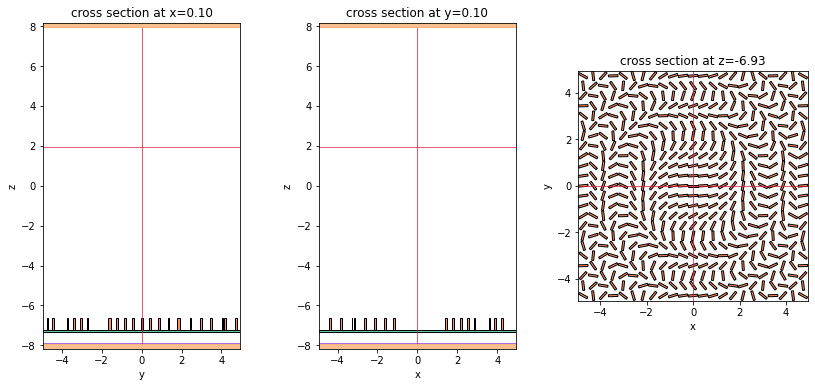

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 6))

# Time the visualization of the 2D plane
sim.plot(x=0.1, ax=ax1);
sim.plot(y=0.1, ax=ax2);
sim.plot(z=-length_z/2 + space_below_sub + thickness_sub + H / 2, ax=ax3);

## Run Simulation

Now we can run the simulation over time and measure the results to plot


In [19]:
job = web.Job(simulation=sim, task_name='metalens', path='data/simulation_data.hdf5')
sim_data = job.run()

[14:05:21] INFO     Creating task.                                              ]8;id=324893;file:///Users/twhughes/Documents/Flexcompute/Tidy3D-client-revamp/notebooks/../tidy3d/web/webapi.py\webapi.py]8;;\:322

[14:05:22] INFO     Uploading the json file                                     ]8;id=525383;file:///Users/twhughes/Documents/Flexcompute/Tidy3D-client-revamp/notebooks/../tidy3d/web/webapi.py\webapi.py]8;;\:331

Output()

[14:05:39] status = preprocess                                               ]8;id=387530;file:///Users/twhughes/Documents/Flexcompute/Tidy3D-client-revamp/tidy3d/web/container.py\container.py]8;;\:101

[14:06:02] status = running                                                  ]8;id=499410;file:///Users/twhughes/Documents/Flexcompute/Tidy3D-client-revamp/tidy3d/web/container.py\container.py]8;;\:101

[14:07:23] status = postprocess                                              ]8;id=285975;file:///Users/twhughes/Documents/Flexcompute/Tidy3D-client-revamp/tidy3d/web/container.py\container.py]8;;\:101

[14:07:24] status = visualize                                                ]8;id=248355;file:///Users/twhughes/Documents/Flexcompute/Tidy3D-client-revamp/tidy3d/web/container.py\container.py]8;;\:101

[14:07:28] status = success                                                  ]8;id=604709;file:///Users/twhughes/Documents/Flexcompute/Tidy3D-client-revamp/tidy3d/web/container.py\container.py]8;;\:101

[14:07:28] INFO     loading SimulationData from simulation_data.hdf5            ]8;id=888201;file:///Users/twhughes/Documents/Flexcompute/Tidy3D-client-revamp/notebooks/../tidy3d/web/webapi.py\webapi.py]8;;\:274

----

As we can see from the logs, the **total time to solve this problem (not including data transfer and pre/post-processing) was about 1 minute!**

For reference, the same problem run with FDTD on a **single CPU core FDTD is projected to take 11 hours!**

## Visualize Fields

Let's see the results of the simulation as captured by our field monitors.

First, we look at the field intensity along the axis of the lens

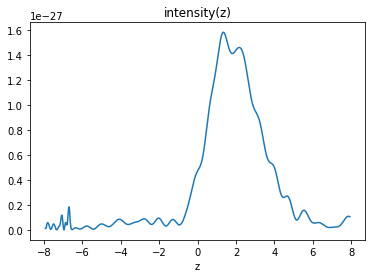

In [30]:
I = abs(sim_data['center'].Ex)**2 + abs(sim_data['center'].Ey)**2 + abs(sim_data['center'].Ez)**2
I.plot(x='z')
plt.title('intensity(z)')
plt.show()

We now can inspect the field patterns on the area monitors using the Tidy3D built in field visualization methods.  For more details see the documentation of [viz_field_2D](../generated/tidy3d.Simulation.viz_field_2D.rst)

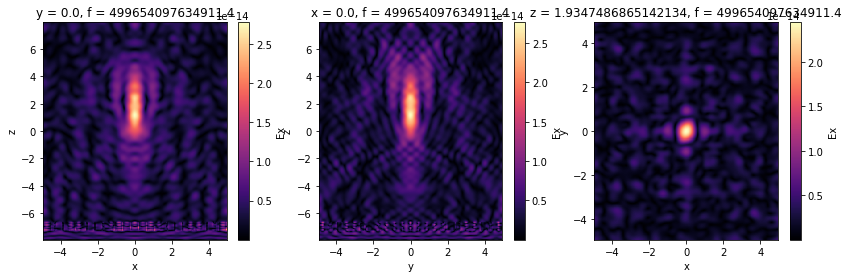

In [36]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
for ax, monitor in zip(axes, ('xz', 'yz', 'focal_plane')):
    abs(sim_data[monitor].Ex).T.plot(cmap='magma', ax=ax)